## Regularisation: motivation

When we framed our learning problem as a minimisation problem, we wrote it down as follows:

$$
\min_{\Lambda \in \mathbb{R}^k} \quad \frac{1}{n} \sum_{i = 1}^n \ell\big( h(X_i), Y_i \big)
$$

We also said that it can be useful to add another term to the function above, called a **regularisation term**.
In this case, the minimisation problem becomes:

$$
\min_{\Lambda \in \mathbb{R}^k} \quad \frac{1}{n} \sum_{i = 1}^n \ell\big( h(X_i), Y_i \big) + \rho R(\Lambda)
$$

We might ask, then, what is this refularisation term?
Why is regularisation a good idea?
When is it advisable, or even necessary, to use a regularisation term?
To address these questions we first have to talk about a more general problem, that of increasing the accuracy and the interpretability of a model.

### Accuracy

As we know, the accuracy of a model depends on both its bias and its variance.
In general, the more data we have, the higher accuracy we can achieve.
This means that, if $p$ is the number of features in the input data, and $n$ is the number of data points we have, we strongly prefer to deal with data for which $n$ is much larger than $p$.
The fewer data points we have, and the more $p$ approaches $n$, the more our methods can suffer from higher variance.

For an extreme case, imagine to fit a simple linear regression model on just two points.
In this case, the bias would be zero, because we can intercept both of them.
But choosing two different points from the underlying distribution can give a potentially very different regression line, demonstrating high variability.
In higher dimensions, we could even have that $p > n$.
**If we use a linear model, then, not only we can intercept all the points, but the hyperplane intercepting them is not even unique.
Such a model would exhibit infinite variance!**

**It turns out, however, that if we constrain (or *limit*, or *shrink*) our coefficients $\Lambda$, then even in pathological cases the variance can be substantially reduced.**
And **one way to constrain the parameters is, you guessed it, via the regularisation function** $R(\Lambda)$.
In this way we can manage to **reduce the variance and, therefore, increase the accuracy of the model.**

But before getting into the details, let's examine the next point.

### Interpretability

In this setting, we define **interpretability in the following way: we want to learn which of the $p$ input features are really correlated with the output.**
Of course, if some of the features are not correlated (or are only very weakly correlated) with the output, we could be better off getting rid of them.
This would give a model which is **easier for a human to interpret**, because it reduces complexity and makes fundamental relations between inputs and outputs emerge.

But how can we "get rid" of some of the input features?
Take the example of multiple linear regression: **to eliminate a feature the corresponding parameter should have value 0.**
In other words, if the estimator is $f(X) = \lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p$, to disregard any effect of (for example) feature 1, we should have $\lambda_1 = 0$.
But if we just fit the model with least squares, it is extremely unlikely that the optimum will have any of the coefficients equal to zero.
Even just **some noise can make the coefficient of a feature which really is uncorrelated** with the output move away from zero.
(Indeed, it can be proven that the event that a coefficient gets value zero happens with probability $0$).

By now you will have already guessed what a possible solution to this problem is: we can **forcibly *shrink* some of the coefficients to take value zero, by choosing an appropriate regularisation function.**

### A prelude to regularisation

Before delving into regularisation and how we can use it to *shrink* the parameters of the model, let's consider a different approach to solve the same problem.
Throughout this class, as an example, I will use a linear regression model but the same considerations could apply to other types of models as well.

Think about the problem of selecting those features that are most relevant to predict the output.
As we said before, one approach to solve this problem in linear regression, is to try to force a good number of coefficients $\lambda$ to zero.
However, we can use a more naive approach as well.
Why don't we just try all possible sets of features?
For each of them, we build a model using only the selected features.
Then, we estimate the error of this model with one of the approaches we know (for example, cross-validation or the bootstrap).
In the end, we choose the model that gives the lowest error estimate.

A way in which we can see this procedure, is to perform model selection.
We consider using a different subset of features as a different model, and we want to establish which one is the best model.
Therefore, we can simply use one of the model selection methods that we already know.

This is a perfectly sensible approach.
Let's see how it could work out.
If we have data with $p$ input features, we would first evaluate the $p$ possible simple linear regression models:
we would simply try to correlate the output with each of the $p$ features individually.
Next, we could try all models with only 2 features.
Once we are done with them, we could move to all models with 3 features.
Etc., etc., until we get to the last model witll all $p$ features.

What is the problem with this approach?
Mainly, computational!
To execute this algorithm, we would have to estimate the MSE of $2^p$ different models.
And, depending on the method we choose for this estimation, we would have to train the model many more times.

Let's see an example of this method using:
* The `auto-mpg` dataset, which has $p = 7$.
* A simple linear regression model (we know it doesn't perform very well for this particular dataset, but we use it here because it's the fastest to train!).
* 5-fold cross-validation to estimate the MSE of each of the candidate models. Remember that there are $2^7 = 128$ such models: one for each possible subset of features.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (14, 10)

In [2]:
# Data preparation, as we have done before.
d = pd.read_csv('../data/auto-mpg.csv')
label_column = 'mpg'
feature_columns = [c for c in d.columns if c != label_column]
X = d[feature_columns]
y = d[label_column].values
p = len(feature_columns)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    StandardScaler(),
    LinearRegression())

In [4]:
from sklearn.model_selection import cross_validate, KFold
from itertools import combinations

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# This will contain the features giving the best model.
best_features = list()
# This will contain the estimated MSE of the best model.
best_mse = float('Inf')

# For all set sizes from 1 to p...
for set_size in range(1, p + 1):
    # Get all the subsets of features with the given size.
    comb = combinations(feature_columns, set_size)    
    
    # For each subset of features with the given size...
    for feature_set in comb:
        # Estimate the MSE of the corresponding model with 5-fold CV.
        restricted_X = X[list(feature_set)]
        scores = cross_validate(model, restricted_X, y, scoring='neg_mean_squared_error', cv=kfold)
        mse = np.mean(scores['test_score']) * -1
        
        # If we have a new best model, update.
        if mse < best_mse:
            best_features = feature_set
            best_mse = mse

In [5]:
print("Best set of features:")
for f in best_features:
    print(f"\t{f}")
    
print("Features left out:")
for f in set(feature_columns) - set(best_features):
    print(f"\t{f}")

print(f"MSE of the best model: {best_mse:.3f}")

Best set of features:
	cylinders
	displacement
	hp
	weight
	year
	origin
Features left out:
	acceleration
MSE of the best model: 11.352


Because this method is so compuationally intensive, we have devised many heuristic variations which try to achieve the same goal of determining the best subset of variables to include in the model, but without trying all possible $2^p$ combinations.

For example, **forward stepwise selection** starts with a model with no predictos.
This is a model which simply returns the average response $\frac{1}{n} \sum_{i=1}^n Y_i$.
It then tries to augment this model, **considering only one feature.**
This means that it trains the $p$ possible simple linear regression models using, in turn, each of the $p$ features.
At the end, it **selects the best such model.**
In the next step, it **fixes this first feature and tries all models with two features**, one of which is the fixed one.
This means it only has to try $p - 1$ models.
If **any of these models is better than the model with 1 feature, it will fix the two selected features and repeat the process with three features (there will be $p - 2$ possibilities left for the third feature).**
The process continues until we get to a number of fixed features for which none of the models obtained by adding one more feature perform better.

A similar idea is that of **backwards stepwise selection**.
The only difference is that this method **starts with the full model** with $p$ features and, at each step, **tries to remove one feature.**
For example, at the first iteration it will consider all $p$ models containing exactly $p - 1$ features.
**If any of these is better than the full model, it will select it and continue with the second iteration.**
In the second iteration, it will consider all the $p - 1$ models obtained from the selected model removing one additional feature.
**The process will continue until removing any feature produces a worse model than the one currently selected.**

#### Example: forward stepwise selection

In the following, I implement the forward stepwise selection algorithm for feature selection.
The MSE of each considered model is estimated using 5-fold cross validation.

In [6]:
from sklearn.metrics import mean_squared_error

# Data preparation, as we have done before.
d = pd.read_csv('../data/auto-mpg.csv')
label_column = 'mpg'
feature_columns = [c for c in d.columns if c != label_column]
X = d[feature_columns].values
y = d[label_column].values

# We use the linear model for our example.
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)
model = make_pipeline(
    StandardScaler(),
    LinearRegression())

# Gets the MSE for a model with zero features, just predicting the mean.
def get_base_mse(y):
    predictions = [np.mean(y)] * len(y)
    return mean_squared_error(predictions, y)

# Gets the MSE of our model, for a given dataset, estimated with 5-fold cross-validation.
def k_fold_mse(X, y):
    scores = cross_validate(model, X, y, scoring = 'neg_mean_squared_error', cv = kfold)
    return np.mean(scores['test_score']) * -1

def forward_stepwise_selection(X, y):
    # Start with the MSE of the zero-features model.
    current_mse = get_base_mse(y)
    
    # This array contains the indices of the columns (features)
    # currently giving the best ecountered model. At the beginning,
    # this is an empty numpy array.
    current_features = np.array([], dtype = int)
    
    # This array contains the indices of all the columns (features)
    # in our dataset. In other words, it is a numpy array containing
    # [0, 1, ..., p-1] where p is the number of features.
    all_features = np.arange(len(feature_columns))
    
    # In the extreme case, when adding a feature always improves the
    # model, we terminate when we added all features.
    # In that case, current_features == all_features.
    while not np.array_equal(current_features, all_features):
        # This variable will contain the index of the *new* feature
        # we want to add to the model. If no improving feature is found,
        # then this variable will keep value None.
        selected_feature = None
        
        # For features not yet in the model...
        for feature in (set(all_features) - set(current_features)):
            # Build a new set of features, adding the new one to the
            # ones already in the model.
            new_features = np.append(current_features, feature)
            
            # Estimate the mse of the new model.
            mse = k_fold_mse(X[:,new_features], y)
            
            # If it's better than the current best, update the best
            # current MSE and mark this feature as the selected new
            # feature.
            if mse < current_mse:
                current_mse = mse
                selected_feature = feature
                
        # If we found an improving feature...
        if selected_feature is not None:
            #... add it to the current features.
            current_features = np.append(current_features, selected_feature)
        else:
            # Otherwise, terminate.
            break
    
    return current_features, current_mse

In [7]:
features, mse = forward_stepwise_selection(X, y)

In [8]:
print("Selected features:")
for idx in sorted(features):
    print(f"\t{d.columns[idx+1]}")

print("Features left out:")
for idx in (set(range(len(feature_columns))) - set(features)):
    print(f"\t{d.columns[idx+1]}")
    
print(f"MSE of the selected model: {mse:.3f}")

Selected features:
	mpg
	cylinders
	displacement
	hp
	acceleration
	year
Features left out:
	weight
MSE of the selected model: 11.352


### Shrinking the parameters: regularisation

As we mentioned before, trying all combinations of features to include in our linear regression model is computationally too expensive.
But there is another issue we pointed out: when the number of samples $n$ is not very large (compared with the number of features $p$) the linear regression model tends to have high variance.
This is exacerbated in the case when $p > n$, when the variance is infinite.

The main idea behind regularisation is that, by constraining the values the parameters can hold, we will reduce the variance of the model.
This will go at the expenses of precision in the fit, so we will introduce some bias.
(We can expect, by the bias-variance trade-off, that when we reduce the variance the bias will go up.)
Regularisation methods are attractive in case our model shows high variance, because we might be able to reduce the variance considerably by introducing a small bias.

In this class, we will consider two types of regularisation: **ridge** regularisation (also called Tychonov regularisation or weight decay) and the **LASSO**.

### Ridge regularisation

We call ridge regularisation the addition of a regularisation term equal to the L2-norm squared of the parameter vector $\Lambda$.
In the case of linear regression, $\Lambda = (\lambda_0, \lambda_1, \ldots, \lambda_p)$, the ridge regularisation term is

$$R(\Lambda) = \lambda_1^2 + \lambda_2^2 + \ldots + \lambda_p^2$$

Notice how we did not include $\lambda_0$, because of the special interpretation of this parameter in the case of linear regression (the intercept when $X = 0$) which means it would not make sense to modify it via shrinking.

If we write out the whole training problem for linear regression, using the MSE a loss function, we get:

$$
\begin{align*}
  & \min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \big(\hat{Y}_i - Y_i\big)^2 + \rho \cdot R(\Lambda) = \\
= & \min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \bigg(\lambda_0 + \sum_{j=1}^p \lambda_j x_{ij} - Y_i \bigg)^2 + \rho \sum_{j=1}^p \lambda_j^2
\end{align*}
$$

Where we have written each point $X_i$ as $(x_{i1}, \ldots, x_{ip})$ and, therefore the prediction for the $i$-th point is

$$\hat{Y}_i = \lambda_0 + \lambda_1 x_{i1} + \ldots + \lambda_p x_{ip} = \lambda_0 + \sum_{j=1}^p \lambda_j x_{ij}$$

We can see that the function we are minimising has two components:

* The first one is, as before, the square loss $\frac{1}{n} \sum_{i=1}^n \big(\hat{Y}_i - Y_i\big)^2$.
This function simply penalises errors and, therefore, contributes to the search for the parameters which minimise the MSE.
* But there is now a second part, the regularisation part: $\rho \sum_{j=1}^p \lambda_j^2$.
Here $\rho \in \mathbb{R}^+$ is a parameter which determines how strong the regularisation is going to be.
Notice that for $\rho = 0$ we would be again in the case of "base" linear regression.
The more $\rho$ grows, however, the more important is the contribution of the regularisation term.
Since this term depends on the squares of the parameters, it will have high value when the parameters are very large in absolute value (i.e., both very large poisitive and negative numbers).
Because we are minimising the function, this means that large terms are penalised.
Therefore we are trying to steer the parameters $\Lambda$ towards having small absolute values.
In other words, we are *shrinking* them towards zero.

The parameter $\rho$, then, can be used to decide in which direction we move in the bias-variance spectrum.
A value of $\rho = 0$ will not add any additional bias, but will leave us with the variance we had at the beginning (which, we are assuming, was high: that's why we are interested in regularisation).
The more $\rho$ increases, the more we constrain the values that parameters $\Lambda$ can take: we reduce the variance but, because we cut off values of $\Lambda$ which were giving lower training MSE's, we increase the bias.

The image below, from the book ISML, shows how the variance (green line) and the bias squared (black line) vary, in an example dataset, as a function of $\rho$.
The pink line is the test MSE, i.e. variance plus bias square.
We can see that there is a value of $\rho$ which gives the lowest MSE.

![](../figures/tychonov-bias-variance.png)

In practice, how do we find the value of $\rho$ which gives the smallest MSE?
For very simple cases (e.g., simple linear regression) we have closed formulas to determine the optimal value.
Most of the time, however, we will resort to hyperparameter tuning.
In this case, because we only have a single real-value hyperparameter, we could use grid search (e.g., try all values of $\rho$ from 0 to 10 with small increments in a log-space), or line search, or any other suitable method.

#### Example: how does the MSE vary with $\rho$?

In the following example, we peform quadratic regression with a Ridge regulariser on the `auto-mpg` dataset.
Because of the high degree, this model should be prone to exhibit high variance and, therefore, is a good candidate to be improved via regularisation.
Let's see how the estimated MSE varies as a function of $\rho$.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Data preparation, as we have done before.
d = pd.read_csv('../data/auto-mpg.csv')
label_column = 'mpg'
feature_columns = [c for c in d.columns if c != label_column]
X = d[feature_columns].values
y = d[label_column].values

# We use the linear model for our example.
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2),
    GridSearchCV(
        estimator = Ridge(),
        cv = kfold,
        scoring = 'neg_mean_squared_error',
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
        iid=True
    )
)

In [12]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              error_score='raise-deprecating',
                              estimator=Ridge(alpha=1.0, copy_X=Tr...
       1.84206997e+00, 2.32995181e+00, 2.94705170e+00, 3.72759372e+00,
       4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
       1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02])},
                              pre_dispatch='2*n_jobs', refit=True,
                              return_train_score=

In [13]:
rhos = [p['alpha'] for p in model[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in model[2].cv_results_['mean_test_score']]

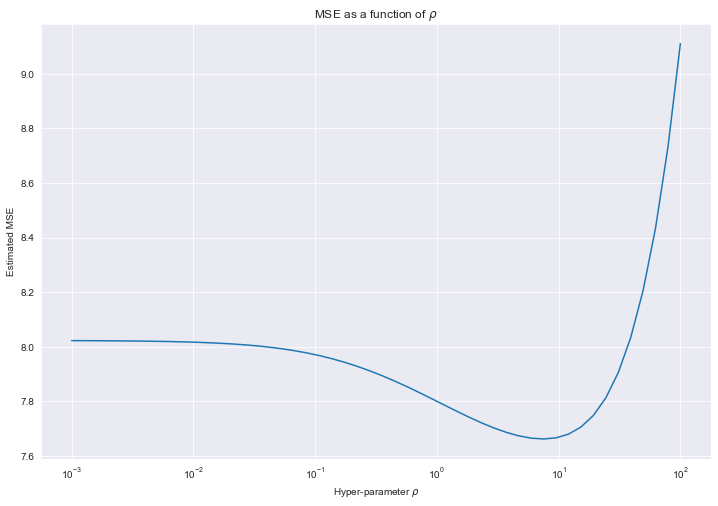

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(rhos, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\rho$")
ax.set_xlabel(r"Hyper-parameter $\rho$")
ax.set_ylabel("Estimated MSE");

As we can see, the plot of the MSE shows the shape that we would expect and attains its minimum for $\rho$ between 1 and 10.

The disadvantage of Ridge regression is that it does not help with respect to the interpretability of the model.
In particular, it does not perform variable selection because the probability that any of the parameters is nullified is the same as before, that is: zero.
The parameters are smaller (closer to zero) but virtually always are not exactly zero, so we cannot discard any variable.

We can convince ourselves that this is the case, by having a look at the model parameters (also called *coefficients* in the following) as a function of $\rho$.

In [15]:
# Because the model coefficients are not returned by GridSearchCV,
# we have to implement this part "manually".

rhos = np.logspace(-2, 3, 50)
coefficients = list()

for rho in rhos:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Ridge(alpha = rho)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)

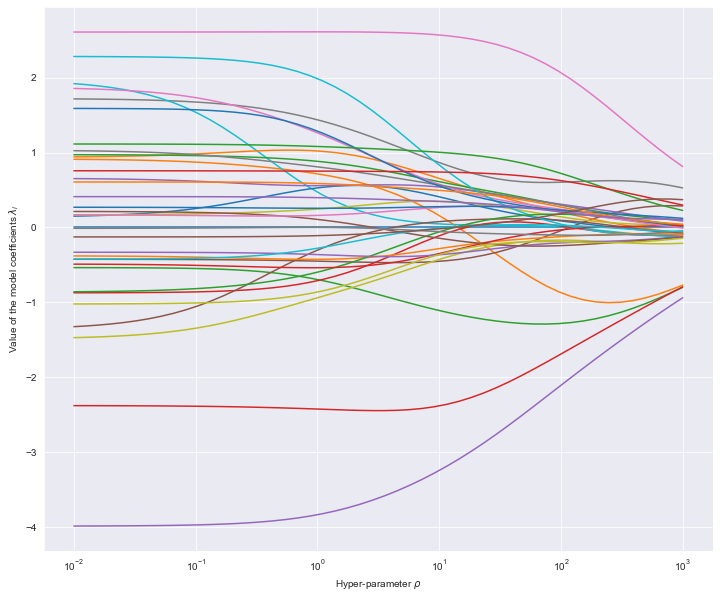

In [16]:
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(rhos, coef_vals)
    
ax.set_xlabel(r"Hyper-parameter $\rho$")
ax.set_ylabel(r"Value of the model coefficients $\lambda_i$")
ax.set_xscale('log');

As we can see, most parameters are squeezed towards zero, but don't manage to reach exactly value zero.
In this way, we don't "get rid" of the corresponding features, meaning that we have a lot of features in the final model and interpretability suffers.

LASSO regularisation is a way to answer this problem.

### LASSO regularisation

The difference between Ridge and LASSO regression is that, instead of taking the L2-norm of $\Lambda$, with LASSO we take the L1-norm.
In other words, in the case of linear regression, the regularisation term is:

$$R(\Lambda) = |\lambda_1| + |\lambda_2| + \ldots + |\lambda_p|$$

In this case, too, we exclude $\lambda_0$ from the regularisation, so the overall training problem (for regression with MSE as the loss function) becomes:


$$
\begin{align*}
  & \min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \big(\hat{Y}_i - Y_i\big)^2 + \rho \cdot R(\Lambda) = \\
= & \min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \bigg(\lambda_0 + \sum_{j=1}^p \lambda_j x_{ij} - y_i \bigg)^2 + \rho \sum_{j=1}^p |\lambda_j|
\end{align*}
$$

Why is LASSO more effective at variable selection, i.e. at setting some of the parameters to zero?
To understand this, we have to first notice the following fact.
Both the ridge and the lasso minimisation problems are unconstrained because $\Lambda$ can take any value in $\mathbb{R}^{p+1}$.
They are equivalent, however, to the following constrained minimisation problems (shown here in the case of linear regression).
For ridge:

$$
\min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \bigg(\lambda_0 + \sum_{j=1}^p \lambda_j x_{ij} - y_i \bigg)^2 + \rho \sum_{j=1}^p \lambda_j^2
$$

$$
\huge\Updownarrow
$$

$$
\min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \bigg(\lambda_0 + \sum_{j=1}^p \lambda_j x_{ij} - y_i \bigg)^2 \quad \text{subject to} \quad \sum_{j=1}^p \lambda_j^2 \leq s
$$

And for LASSO:

$$
\min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \bigg(\lambda_0 + \sum_{j=1}^p \lambda_j x_{ij} - y_i \bigg)^2 + \rho \sum_{j=1}^p |\lambda_j|
$$

$$
\huge\Updownarrow
$$

$$
\min_{\Lambda \in \mathbb{R}^{p+1}} \quad \frac{1}{n} \sum_{i=1}^n \bigg(\lambda_0 + \sum_{j=1}^p \lambda_j x_{ij} - y_i \bigg)^2 \quad \text{subject to} \quad \sum_{j=1}^p |\lambda_j| \leq s
$$

This means that, in both cases, there exist some $s \in \mathbb{R}^+$ for which the constrained and the unconstrained problem are equivalent, i.e. have the same minimiser.
An interpretation of the constrained version of the problem is that we are constraining the L2- and L1- norms (respectively) of the parameter vector $\Lambda$ to be smaller than a given threshold $s$.
When this threshold is very high, it is almost as if we were imposing no threshold at all, and this corresponds to $\rho = 0$.
When the threshold is low, we are forcing the parameters to be very small, and this corresponds to a large $\rho$.

Why is this way of seeing the minimisation problem more useful?
Because, for a fixed $s$, we can easily depict the feasible area of the minimisation problem, that is the region of the parameter space $\mathbb{R}^{p+1}$ which contains admissible points.
Let's visualise this in the easiest case, when $X \in \mathbb{R}^2$: we are using linear regression on a 2-dimensional input.
In this case, we only have two parameters ($\lambda_1$ and $\lambda_2$, disregarding the intercept $\lambda_0$).
The ridge regulariser is $R(\Lambda) = \lambda_1^2 + \lambda_2^2$ and the LASSO regulariser is $R(\Lambda) = |\lambda_1| + |\lambda_2|$.
Analogously, the constrained minimisation problems are

$$
\min_{\lambda_1, \lambda_2 \in \mathbb{R}} \quad \frac{1}{n} \sum_{i = 1}^n \bigg(\lambda_0 + \lambda_1 x_{i1} + \lambda_2 x_{i2} - y_i \bigg)^2 \quad \text{subject to} \quad \lambda_1^2 + \lambda_2^2 \leq s
$$

and

$$
\min_{\lambda_1, \lambda_2 \in \mathbb{R}} \quad \frac{1}{n} \sum_{i = 1}^n \bigg(\lambda_0 + \lambda_1 x_{i1} + \lambda_2 x_{i2} - y_i \bigg)^2 \quad \text{subject to} \quad |\lambda_1| + |\lambda_2| \leq s
$$

The following picture, taken by the ISML book, shows in blue the feasible region for the ridge problem.
Notice how the book calls $\beta_1$ and $\beta_2$ the two parameters we call $\lambda_1$ and $\lambda_2$.
The point $\hat{\beta}$ in the figure is the optimal parameter configuration (what we would denote as $\Lambda^*$) when we disable regularisation constraints $\lambda_1^2 + \lambda_2^2 \leq s$.
In other words, it is the minimiser of the training problem without regularisation term or, alternatively, when $\rho = 0$.
The red lines around $\hat{\beta}$ are the level sets of the objective function of the minimisation problem without the regularisation term.
This means that all parameter configuration on a red line yield the same MSE.

![](../figures/ridge-region.png)

If we had no regularisation constraints, our optimum would be $\hat{\beta}$.
But because we have ridge constraints, we are forced to take a point in the blue region.
The best point in the blue region we can take, then, will lie on its border... imagine it as it's trying to escape the blue region prison, to go and meet the unconstrained optimum $\hat{\beta}$.
In particular, the point will lie at the intersection of the blue circle with its tangent red level set.

Now notice that, because the blue feasible region is a circle, it has smooth borders.
So, the probability that the blue circle and the red ellipses meet exactly on one of the axes (corresponding to one of the parameters being 0) is very small.
This is a geometric intuitive explanation of why optimal parameters with ridge regularisation are seldom null.

The next picture shows the same set-up, but for LASSO regularisation.

![](/figures/lasso-region.png)

Here the blue region is given by constraints $|\lambda_1| + |\lambda_2| \leq s$.
Notice how now the feasible region has corners!
This means that, when looking for the level set which is tangent to the blue region, it is now much more likely that it will meet the feasible region at a corner.
But the blue region always has corners on the axes, so the optimal parameter in the feasible region is more likely to lie on one axis and, therefore, have one component equals to zero.

Generalising to the multi-dimensional case, we can se that the LASSO increases the chance that $\lambda^*$ lies on some axis, i.e., that some of the parameters will be null.
This means that the corresponding variable can be "discarded" from the model.
In this way, we obtain a model which is easier to interpret, because it contains fewer features.

#### Example: how does the MSE vary with $\rho$?

We use the same quadratic regression model we used for Ridge, but this time we apply LASSO regularisation.

In [21]:
from sklearn.linear_model import Lasso

model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000, tol = 0.05),
        cv = kfold,
        scoring = 'neg_mean_squared_error',
        param_grid = {'alpha': np.logspace(-5, -2.5, 50)},
        iid=True
    )
)

In [22]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('gridsearchcv',
                 GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              error_score='raise-deprecating',
                              estimator=Lasso(alpha=1.0, copy_X=Tr...
       4.29193426e-04, 4.82695744e-04, 5.42867544e-04, 6.10540230e-04,
       6.86648845e-04, 7.72244995e-04, 8.68511374e-04, 9.76778110e-04,
       1.09854114e-03, 1.23548289e-03, 1.38949549e-03, 1.56270698e-03,
       1.75751062e-03, 1.97659807e-03, 2.22299648e-03, 2.50011038e-03,
       2.81176870e-03, 3.16227766e-03])},
                              pre_dispatch='2*n_jobs', refit=True,
                              return_train_score=

In [23]:
rhos = [p['alpha'] for p in model[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in model[2].cv_results_['mean_test_score']]

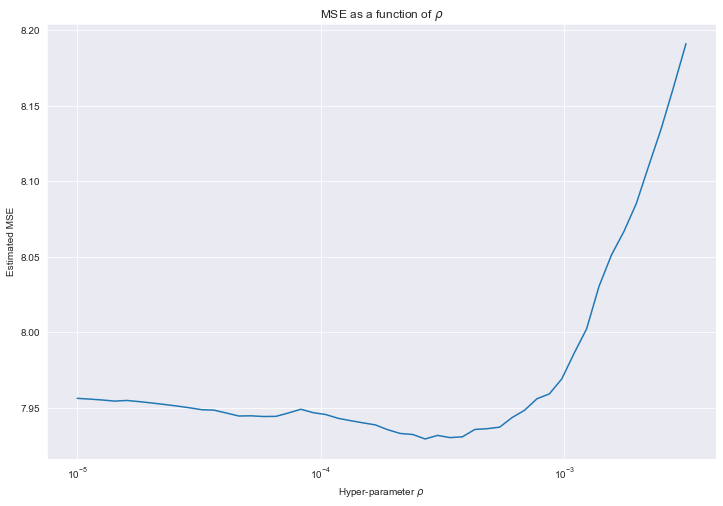

In [24]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(rhos, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\rho$")
ax.set_xlabel(r"Hyper-parameter $\rho$")
ax.set_ylabel("Estimated MSE");

We can notice that the overall shape of the curve is similar to that we obtained for Ridge regression.
For the LASSO, however, the curve is "bumpier".
This can be due to the fact that some of the Gradient-Descent-trained models used during the experiment above might not be optimal.
The use of the absolute value, in fact, confers undesirable properties to the objective function (e.g., discontinuities in the gradients) and this makes training harder.

Let's now have a look at how the model parameters change with $\rho$.

In [25]:
# Because the model coefficients are not returned by GridSearchCV,
# we have to implement this part "manually".

rhos = np.logspace(-5, 0, 100)
coefficients = list()

for rho in rhos:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Lasso(alpha = rho, max_iter = 10000, tol = 0.05)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)

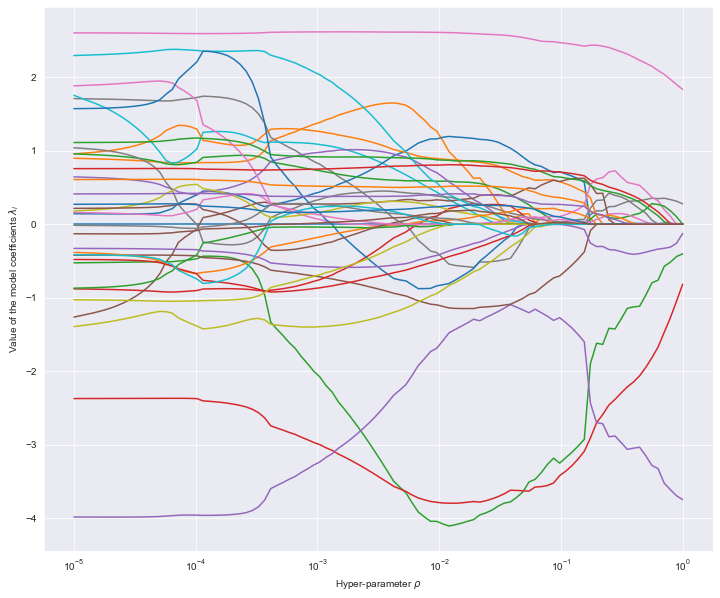

In [26]:
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(rhos, coef_vals)
    
ax.set_xlabel(r"Hyper-parameter $\rho$")
ax.set_ylabel(r"Value of the model coefficients $\lambda_i$")
ax.set_xscale('log');

It's hard to spot it, but most of the lines are flat on zero.
To better see this effect, let's plot instead of the individual coefficient values, just how many coefficients were non-zero.

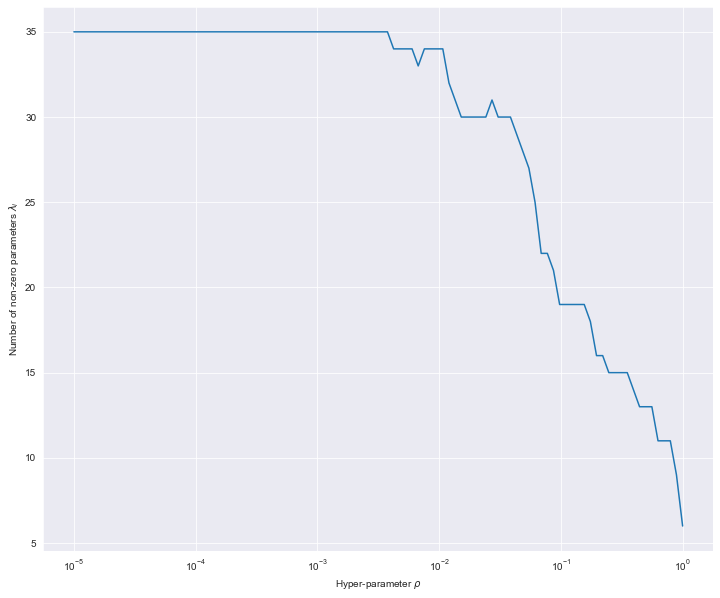

In [27]:
num_rhos = 100
non_zeroes = [len([cf[i] for cf in coefficients if cf[i] != 0]) for i in range(num_rhos)]
fig, ax = plt.subplots(figsize = (12, 10))

ax.plot(rhos, non_zeroes)
    
ax.set_xlabel(r"Hyper-parameter $\rho$")
ax.set_ylabel(r"Number of non-zero parameters $\lambda_i$")
ax.set_xscale('log');

### Comparing ridge and LASSO

I quote here the final remarks from the ISML book:

> Neither ridge regression nor the lasso will universally dominate the other.
In general, one might expect the lasso to perform better in a setting where a relatively small number of predictors have substantial coefficients, and the remaining predictors have coefficients that are very small or that equal zero.
Ridge regression will perform better when the response is a function of many predictors, all with coefficients of roughly equal size.
However, the number of predictors that is related to the response is never known a priori for real data sets.
A technique such as cross-validation can be used in order to determine which approach is better on a particular data set.
As with ridge regression, when the least squares estimates have excessively high variance, the lasso solution can yield a reduction in variance at the expense of a small increase in bias, and consequently can generate more accurate predictions.
Unlike ridge regression, the lasso performs variable selection, and hence results in models that are easier to interpret.